In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

class StopExecution(Exception):
    def _render_traceback_(self):
        return []



In [2]:
import sys
sys.path.append("..")
import pickle as pkl
import hist
from analyzer.core import AnalysisResult
from analyzer.datasets import SampleManager
import math
import torch
import gpytorch
from analyzer.plotting.core_plots import *
loadStyles()
import matplotlib
from torch.masked import masked_tensor, as_masked_tensor
matplotlib.rcParams['figure.figsize'] = (3, 3)

In [3]:
from fitting import regression



In [4]:
res = AnalysisResult.fromFile("../results/newanalyzer.pkl")

In [5]:
sample_manager = SampleManager()
sample_manager.loadSamplesFromDirectory("../datasets")

In [6]:
hists = res.getMergedHistograms(sample_manager)

In [110]:
complete_hist = hists["ratio_m14_vs_m24"]
narrowed = hist
#orig =  m14_vs_m24[...,hist.loc(1100):hist.loc(2500),hist.loc(400):hist.loc(2000)]
#orig =  complete_hist[...,hist.loc(0):hist.loc(3000),hist.loc(0):hist.loc(1)]
orig =  complete_hist[...,hist.loc(1150):hist.loc(3000),hist.loc(0.4):hist.loc(1)]
#orig = orig / orig.values().max()
#orig =  complete_hist[...,hist.loc(1150):hist.loc(3000),hist.loc(400):hist.loc(3000)]#orig =  complete_hist[...,hist.loc(0):hist.loc(3000),hist.loc(0):hist.loc(3000)]
narrowed = orig
narrowed = orig[...,::hist.rebin(1),::hist.rebin(1)]
qcd_hist = narrowed["Skim_QCDInclusive2018",...]
orig_qcd_hist = orig["Skim_QCDInclusive2018",...]

sig_hist = narrowed["signal_312_1500_900",...]

qcd_hist = narrowed["Skim_QCDInclusive2018",...] + 0 * sig_hist


In [111]:
def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax

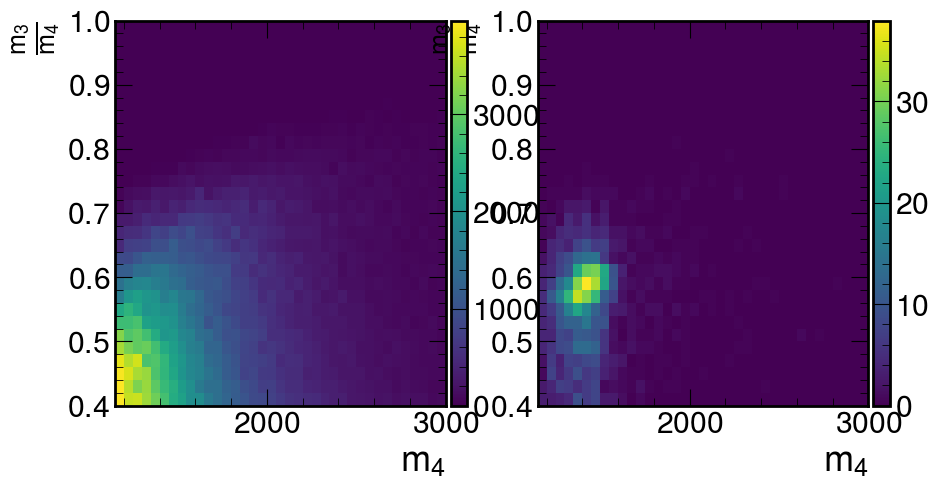

In [112]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
_ = drawAs2DHist(ax[0], PlotObject.fromHist(qcd_hist))
_ = drawAs2DHist(ax[1], PlotObject.fromHist(sig_hist))

In [113]:
sig_values = torch.from_numpy(sig_hist.values()).T
(train, test), centers_mask = regression.preprocessHistograms(qcd_hist, [(0,0),(0.0,0.0)])


torch.Size([1110])
torch.Size([1110])


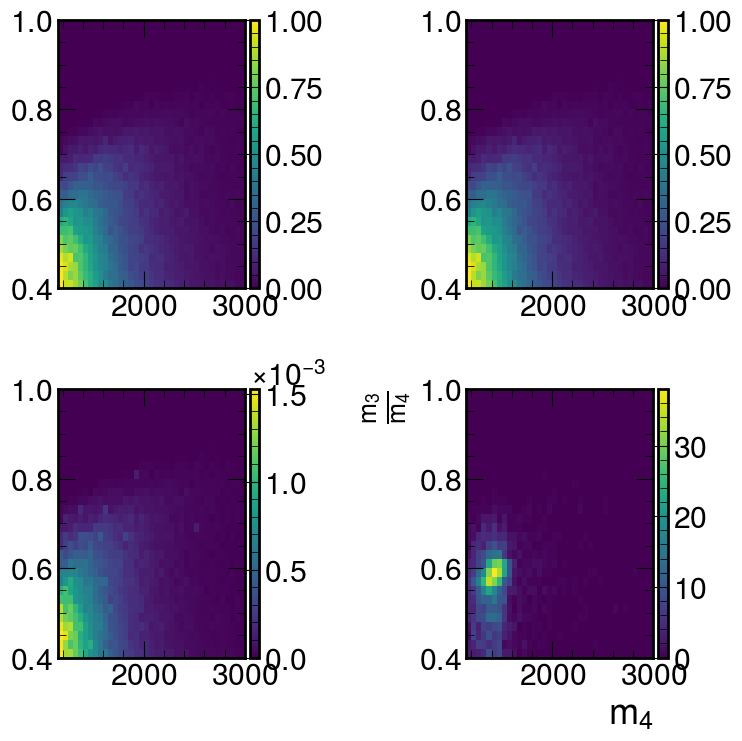

In [114]:
from analyzer.plotting.core_plots import *
fig,ax = plt.subplots(2,2, figsize=(8,8))
def simpleGrid(ax, edges,iny):
    X,Y = np.meshgrid(*edges)
    z=iny
    Z=z.reshape(len(edges[1])-1,len(edges[0])-1)
    f = ax.pcolormesh(X,Y,Z)
    addColorbar(ax,f)
    return f


print(train.outputs.shape)
print(test.outputs.shape)
simpleGrid(ax[0,0],test.edges, test.outputs)
simpleGrid(ax[0,1],test.edges, np.ma.masked_where(torch.flatten(centers_mask), test.outputs))
simpleGrid(ax[1,0],test.edges, test.variances)

drawAs2DHist(ax[1,1], PlotObject.fromHist(sig_hist))
fig.tight_layout()

In [115]:
from fitting import regression
model,likelihood = regression.createModel(train)

model,likelihood = regression.optimizeHyperparams(model,likelihood, train, iterations=100)

pred = regression.getPrediction(model, likelihood, test)

Iter 1 - Loss: -2.316   lengthscale: 0.6931,0.6931  scale: 0.693  mean:0.000 noise:0.000 
Iter 10 - Loss: -2.633   lengthscale: 0.5021,0.4947  scale: 0.933  mean:-0.062 noise:0.000 
Iter 20 - Loss: -2.686   lengthscale: 0.3886,0.3469  scale: 1.171  mean:0.288 noise:0.000 
Iter 30 - Loss: -2.410   lengthscale: 0.3613,0.2769  scale: 1.276  mean:0.244 noise:0.000 
Iter 40 - Loss: -2.366   lengthscale: 0.4024,0.2526  scale: 1.271  mean:0.072 noise:0.000 
Iter 50 - Loss: -2.587   lengthscale: 0.4715,0.2489  scale: 1.205  mean:0.061 noise:0.000 
Iter 60 - Loss: -2.513   lengthscale: 0.5312,0.2528  scale: 1.120  mean:0.184 noise:0.000 
Iter 70 - Loss: -2.760   lengthscale: 0.6064,0.2582  scale: 1.035  mean:0.259 noise:0.000 
Iter 80 - Loss: -2.757   lengthscale: 0.6419,0.2570  scale: 0.973  mean:0.215 noise:0.000 
Iter 90 - Loss: -2.761   lengthscale: 0.5973,0.2536  scale: 0.914  mean:0.185 noise:0.000 
Iter 100 - Loss: -2.709   lengthscale: 0.5504,0.2499  scale: 0.856  mean:0.217 noise:0.000

/srv/cmsmlenv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


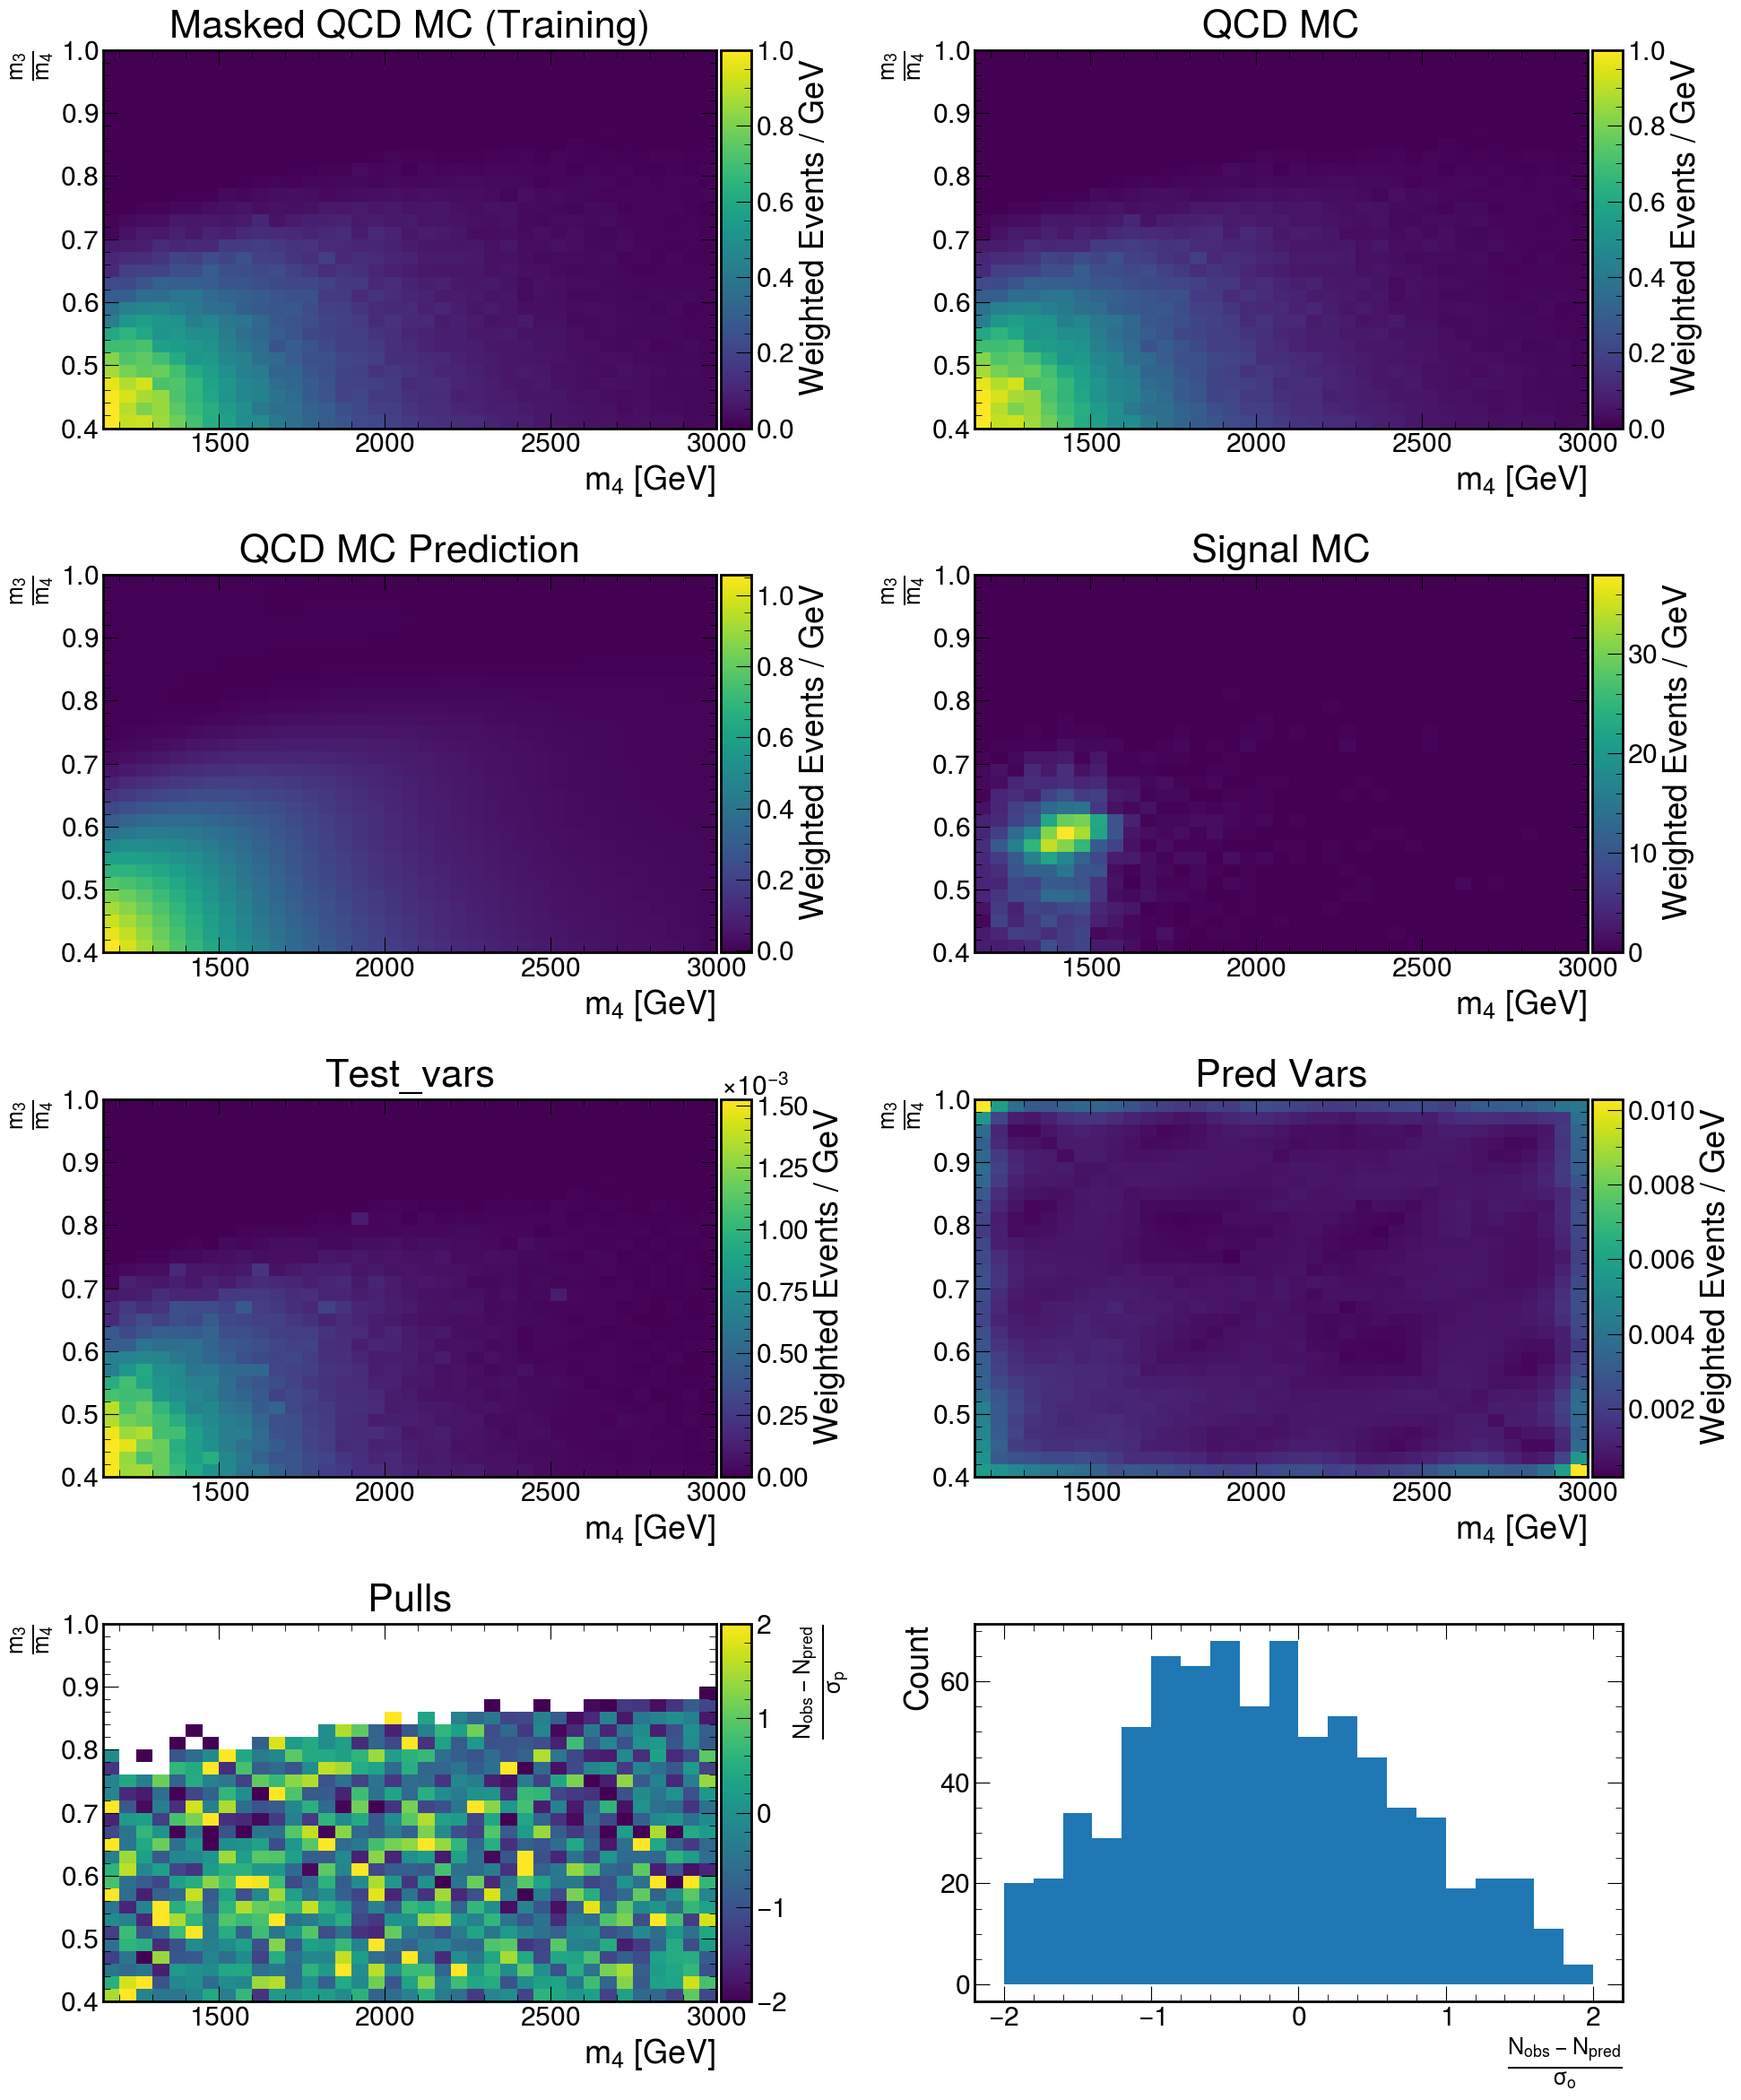

In [116]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools as it
from analyzer.plotting.core_plots import *

pred_mean = pred.mean
pred_var = pred.variance


all_pulls = (pred_mean - test.outputs) / torch.sqrt(test.variances)
all_x2 = (pred_mean - test.outputs)**2 / test.variances
x2 = torch.sum(all_x2)

def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax


fig, ax=plt.subplots(4,2, figsize=(20,24), layout="tight")

f = simpleGrid(ax[0,0], test.edges, np.ma.masked_where(centers_mask,torch.reshape(test.outputs, centers_mask.shape)))
ax[0,0].set_title("Masked QCD MC (Training)")

f = simpleGrid(ax[1,0], test.edges, pred_mean)
ax[1,0].set_title("QCD MC Prediction")



f = simpleGrid(ax[0,1], test.edges, test.outputs)
#f=ax[0,1].pcolormesh(*torch.unbind(centers_grid,axis=2), bin_values)
ax[0,1].set_title("QCD MC")

drawAs2DHist(ax[1,1], PlotObject.fromHist(sig_hist))
addTitles2D(ax[1,1], PlotObject.fromHist(sig_hist))
ax[1,1].set_title("Signal MC")


f = simpleGrid(ax[2,0], test.edges, test.variances)
ax[2,0].set_title("Test_vars")


f = simpleGrid(ax[2,1], test.edges, pred_var)
ax[2,1].set_title("Pred Vars")


f = simpleGrid(ax[3,0], test.edges, (pred_mean - test.outputs)/ torch.sqrt(test.variances))
f.set_clim(-2,2)
ax[3,0].set_title("Pulls")


for  x in it.chain(*ax):
    addTitles2D(x, PlotObject.fromHist(sig_hist))

ax[3,0].cax.set_ylabel(r"$\frac{N_{obs}-N_{pred}}{\sigma_{p}}$")

import uhi

p = PlotObject.fromHist(uhi.numpy_plottable.ensure_plottable_histogram(np.histogram(all_pulls[torch.abs(all_pulls) < 20], bins=20,range=(-2,2))))
drawAs1DHist(ax[3,1], p, yerr=False)
ax[3,1].set_xlabel(r"$\frac{N_{obs}-N_{pred}}{\sigma_{o}}$")
ax[3,1].set_ylabel("Count")


fig.savefig("../figures/current_gp_work.pdf")




In [117]:
from analyzer.plotting.core_plots import PlotObject
from analyzer.plotting.core_plots import drawAsScatter
from fitting.plot_tools import generatePulls


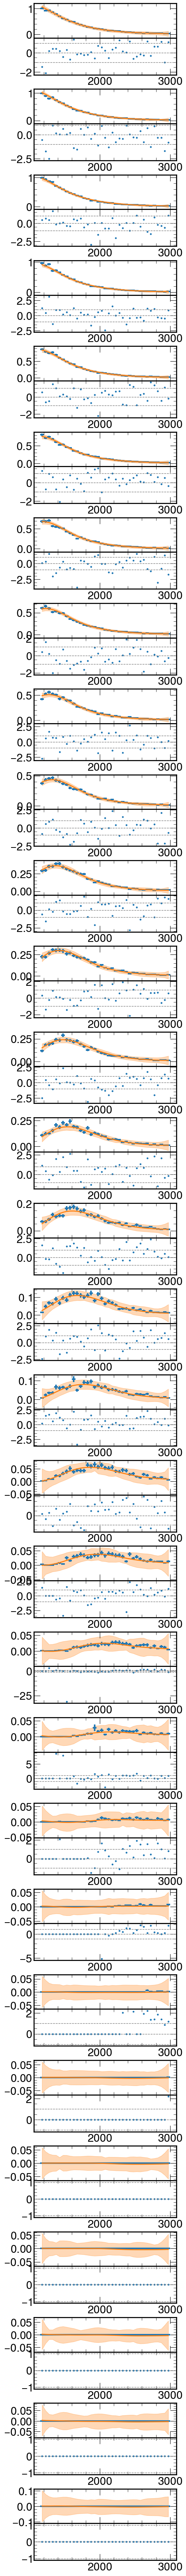

In [119]:
import importlib
dim = 1
slices=  np.unique(test.inputs[:,dim])

def sliceGPH(pred,data, val, dim=1):
    mask = torch.isclose(data.inputs[:,dim],torch.tensor(val,dtype=torch.float64), atol=1e-3)
    pred_mean = pred.mean[mask]
    pred_var = pred.variance[mask]
    return pred_mean, pred_var
    
def sliceDH(data, val,dim=1):
    mask = torch.isclose(data.inputs[:,dim],torch.tensor(val,dtype=torch.float64), atol=1e-3)
    return data.outputs[mask], data.variances[mask]

fig,axes = plt.subplots(len(slices),figsize=(5,len(slices)*3))
for ax,s in zip(axes,slices):
    data,variances = sliceDH( test, s, dim)
    mean, model_var = sliceGPH(pred, test, s,dim)
    model_obj = PlotObject.fromNumpy((mean, test.edges[1-dim]), model_var)

    generatePulls(ax, (test.edges[1-dim], data, variances), (mean, model_var))

fig.savefig("../figures/slices.pdf")
